The goal of this project is to predict whether an individual suffers from cardiovascular heart disease using some predictors and to find the main risk factors for a cardiovascular heart disease. This information helps to improve preventive medical checkups and to react quicker in emergencies.

Goal: Predict whether a patient should be diagnosed with Heart Disease.

1 = patient diagnosed with Heart Disease
0 = patient not diagnosed with Heart Disease


In [196]:
pip install dmba

In [261]:
import pandas as pd
import numpy as np

### Utility
import math
import warnings
import string

### Plotting
# Matplotlib
import matplotlib.pyplot as plt
# Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

#Tree
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Seaborn
import seaborn as sns

import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary

warnings.filterwarnings("ignore")

In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
df= pd.read_csv("/content/drive/MyDrive/BDA Data/cardio.csv",delimiter=';')

In [200]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Pre-processing and EDA

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [202]:
num_missing_values = df.isna().sum().sum()
num_missing_values

0

In [203]:
#dropping ID columns
df.drop(['id'], axis=1,inplace=True)

In [204]:
duplicate_sum = df.duplicated().sum()
duplicate_sum

24

In [205]:
# dropping the duplicates
df.drop_duplicates(keep = 'first', inplace = True)

<Axes: >

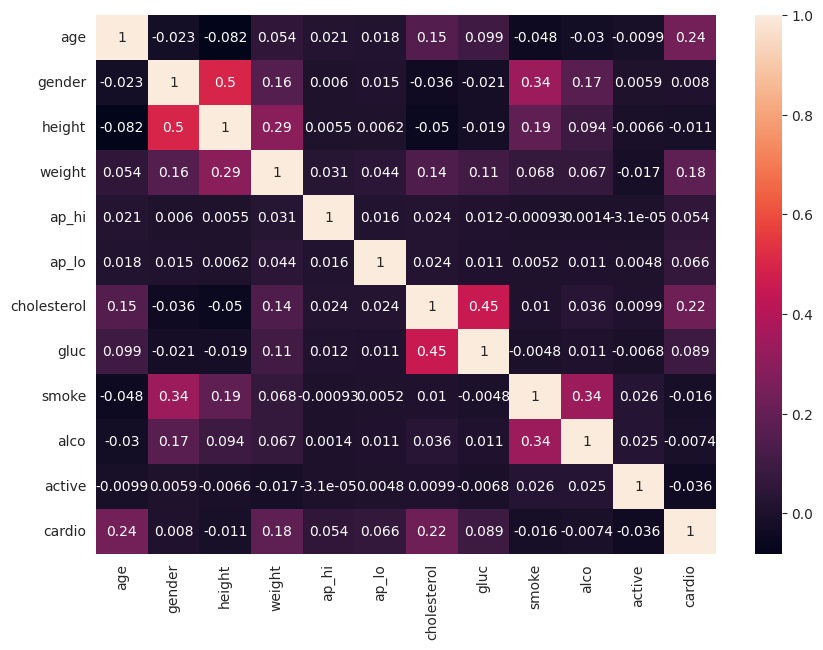

In [206]:
# check correlations
plt.subplots(figsize=(10,7))
sns.heatmap(df.corr(), annot=True)

From the above heatmap, we see that no features directly correlate with the label (cardio) and that generally, there do not exist significant correlations between other variables. However, correlations exist between a select few variables:

- Height and gender are correlated with a score of 0.5.
- Glucose and cholesterol are correlated with a score of 0.45.
- Smoking habits and gender are correlated with a score of 0.34.

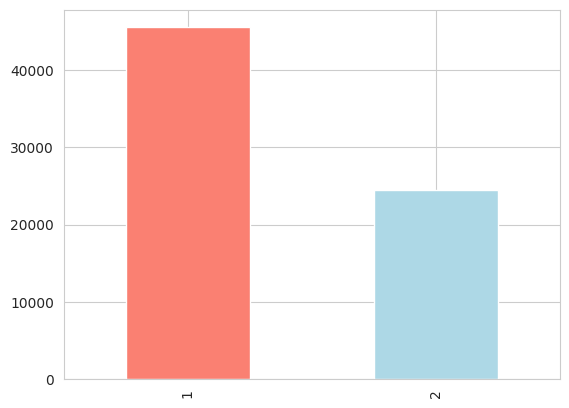

In [207]:
# Get the count of each gender
gender_count = df['gender'].value_counts()
df.gender.value_counts().plot(kind="bar", color=["salmon", "lightblue"])
plt.show()

gender
1    161.354347
2    169.948134
Name: height, dtype: float64


<Axes: xlabel='gender'>

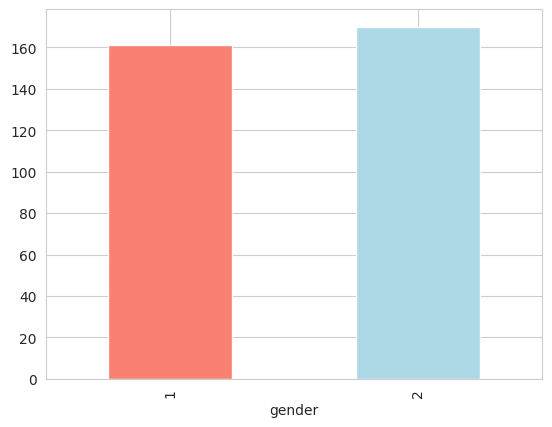

In [208]:
# Get the count of each gender
avg_height = df.groupby('gender')['height'].mean()
print(avg_height)
avg_height.plot(kind="bar", color=["salmon", "lightblue"])


gender
1    1161
2    2603
Name: alco, dtype: int64


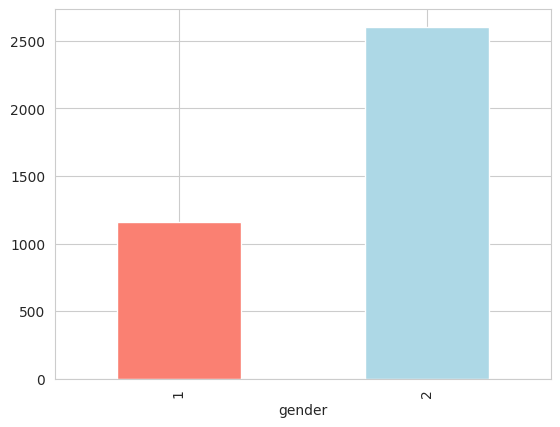

In [209]:
alcohol=df.groupby('gender')['alco'].sum()
print(alcohol)
ax=alcohol.plot(kind="bar", color=["salmon", "lightblue"])


In [210]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


#Observations


- 'Age' column has to be recalculated it has a minimum values of 10789' which is unrealistic therefore they represents a missing/incorrect value.
- 'Weight' column have unrealistic min/max values.
- Systolic blood pressure "ap_hi" and Diastolic blood pressure "ap_lo" cannot be negative
- If ap_hi and ap_lo are more than 180 and 120 mmHg respectively then it is an hypertensive crisis, which is an emergency case. Therefore max values are not realistic.

#Check Outliers

['age' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol' 'gluc'
 'smoke' 'alco' 'active' 'cardio']


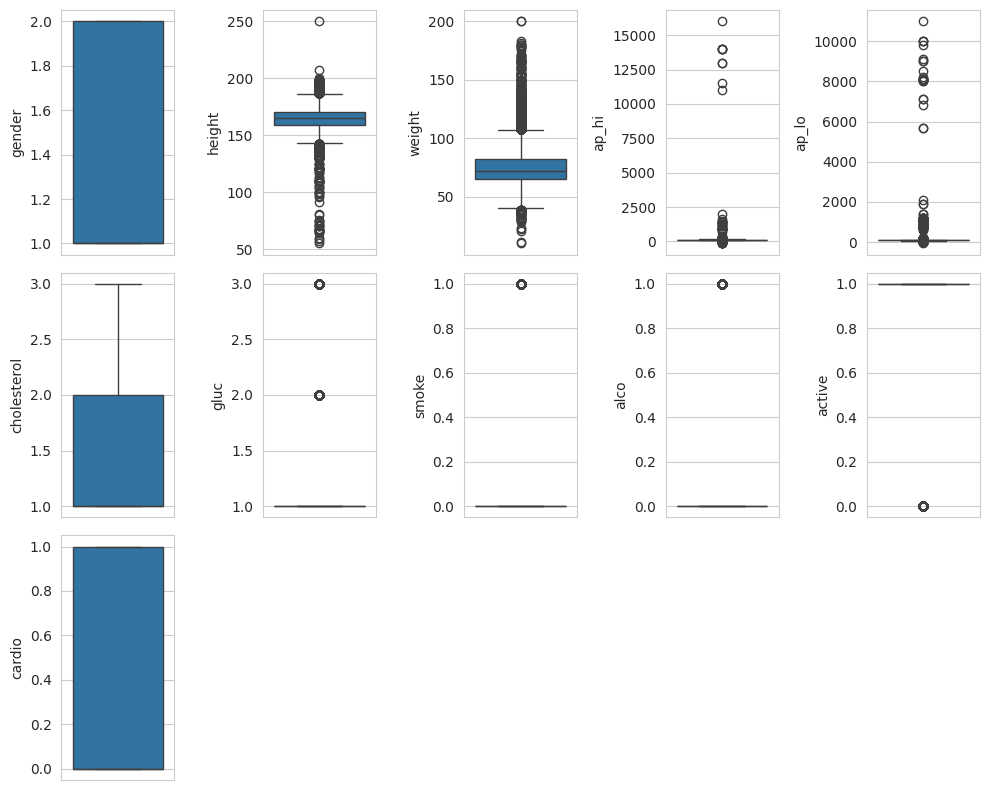

In [211]:
# check outliers
def check_outliers(df):
    l = df.columns.values
    number_of_columns=(len(l)-1)//2
    number_of_rows = 2
    print(l)
    plt.figure(figsize=(2*number_of_columns,4*number_of_rows))
    for i in range(1,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i)
        sns.set_style('whitegrid')
        sns.boxplot(df[l[i]],orient='v')
        plt.tight_layout()

check_outliers(df)

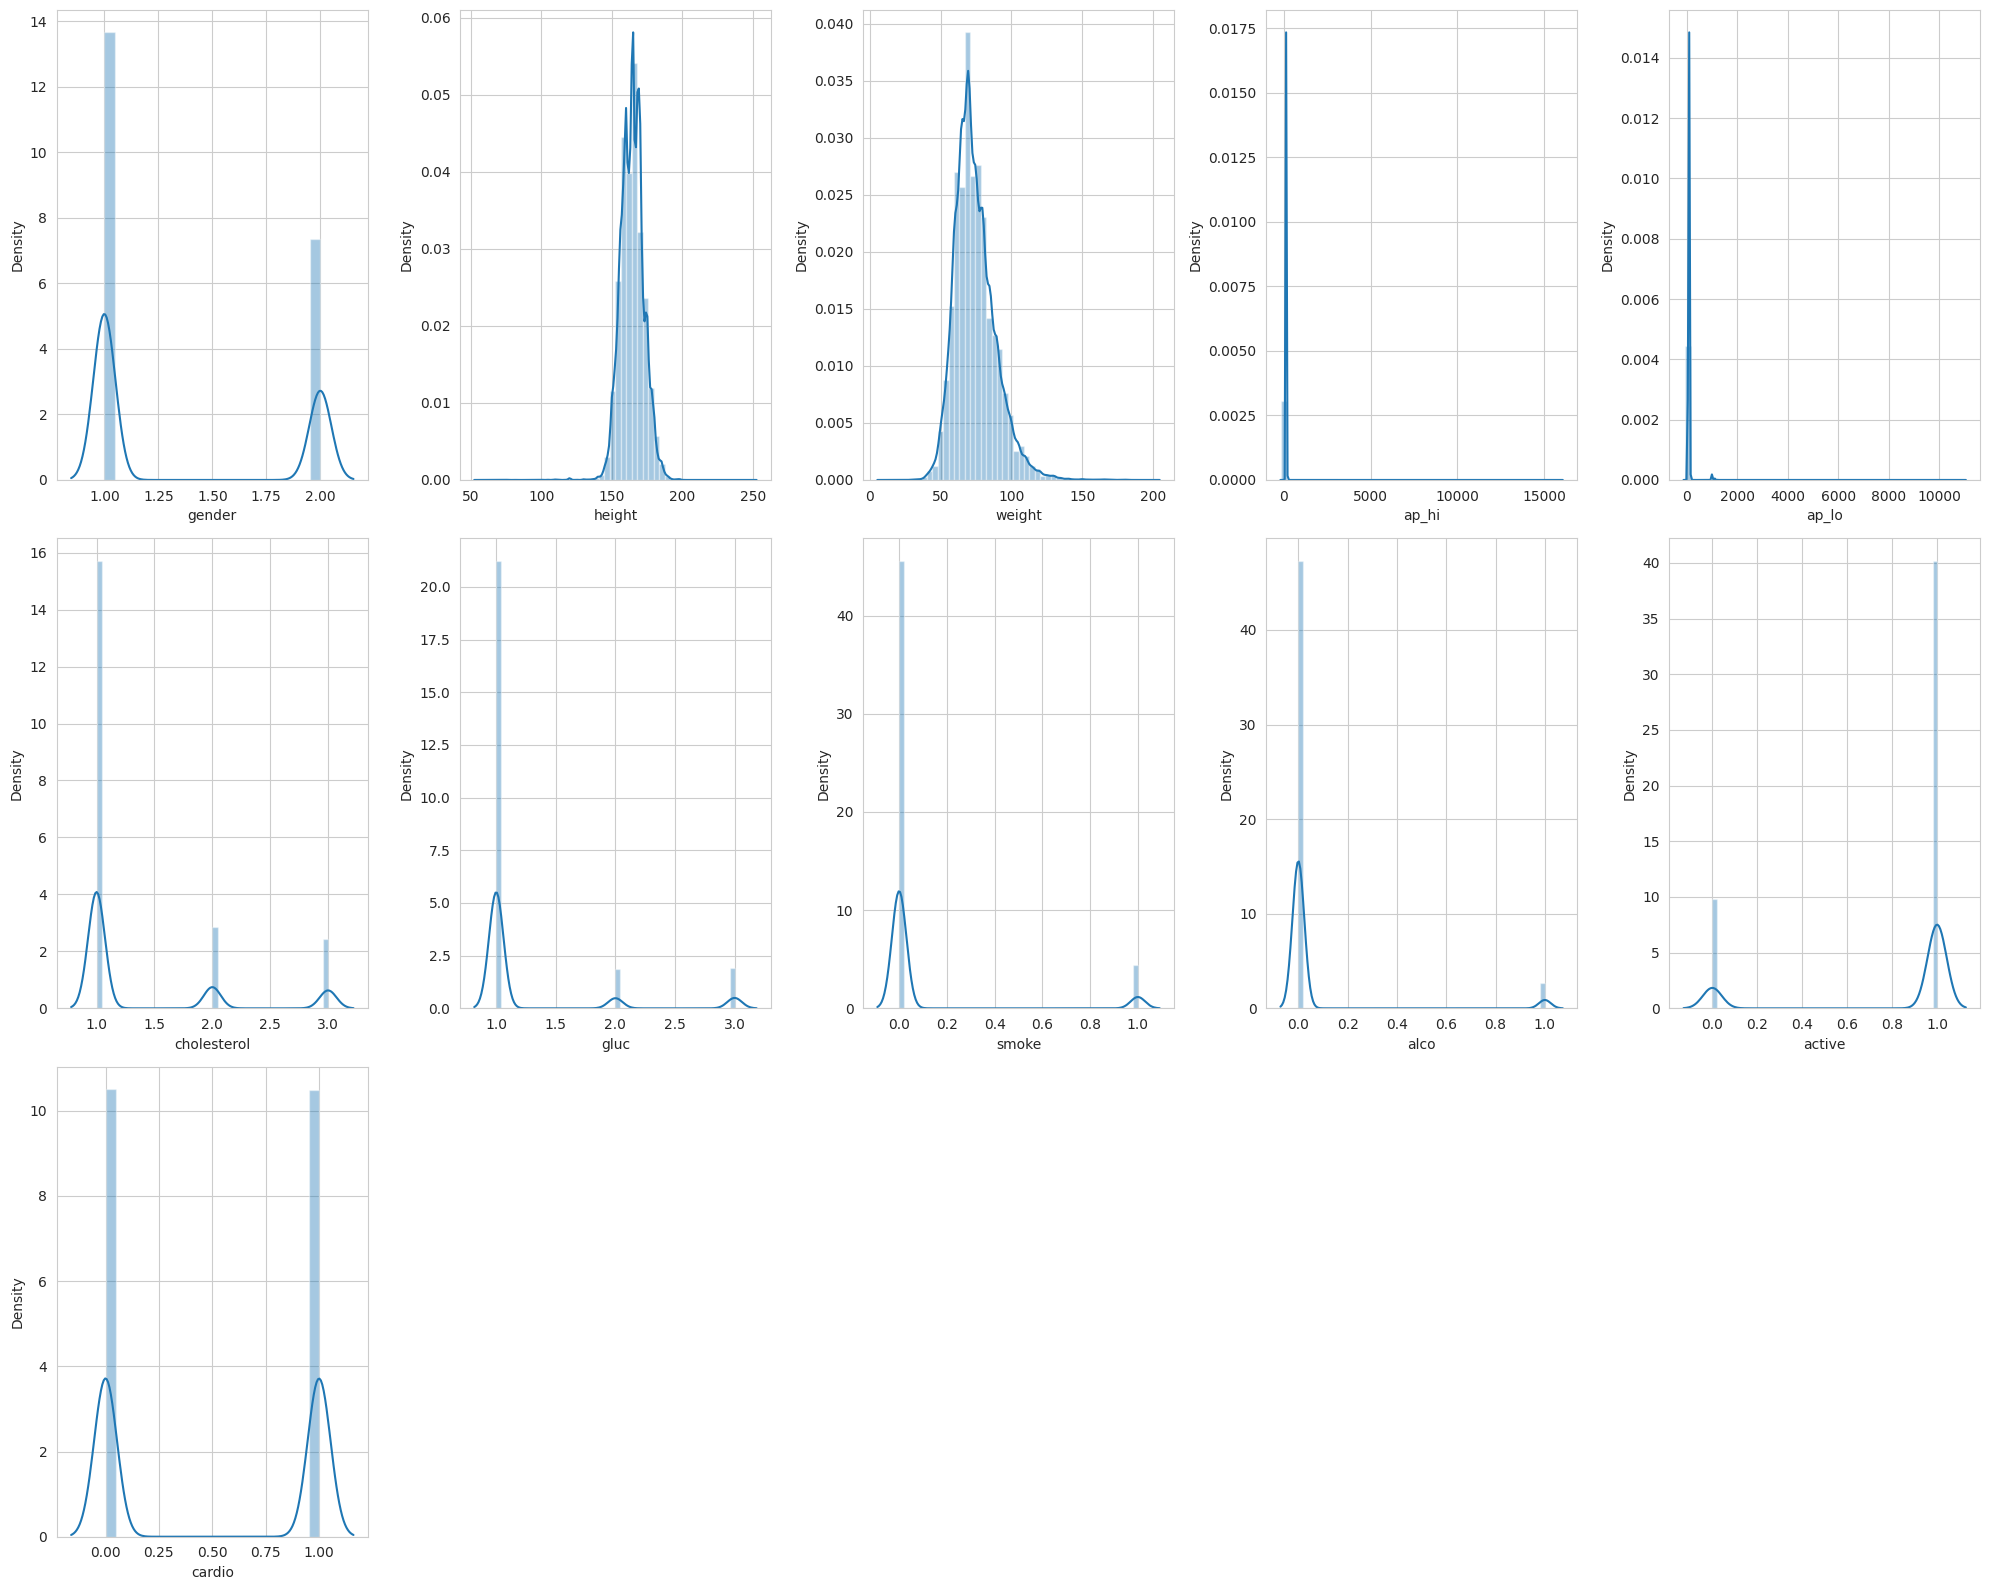

In [212]:
# check distribution and skew
def check_dist(df):
    l = df.columns.values
    number_of_columns=(len(l)-1)//2
    number_of_rows = 2

    plt.figure(figsize=(4*number_of_columns,8*number_of_rows))
    for i in range(1,len(l)):
        plt.subplot(number_of_rows+1,number_of_columns,i)
        sns.distplot(df[l[i]],kde=True)
        plt.tight_layout()

check_dist(df)

In [213]:
df = df[ (df['ap_lo'] >= 0) & (df['ap_hi'] >= 0) ]  #considering positive values remove negative values
df = df[ (df['ap_lo'] <= 120) & (df['ap_hi'] <= 180) ]  #remove fishy data points
df = df[ (df['ap_lo'] < df['ap_hi']) ]  #remove systolic higher than diastolic

Converting age from days to years

In [214]:
df['age']=df['age'].apply(lambda x: x/365)

#calculating a new feature Pulse

In [215]:
#since there were not many variables showing cor-relation with cardio, we tried creating a new variable pulse
def pulse(data):
    return np.subtract(data['ap_hi'], data['ap_lo'])

df['pulse'] = df.apply(pulse, axis=1)

# Removing height, weight outliers

<Axes: >

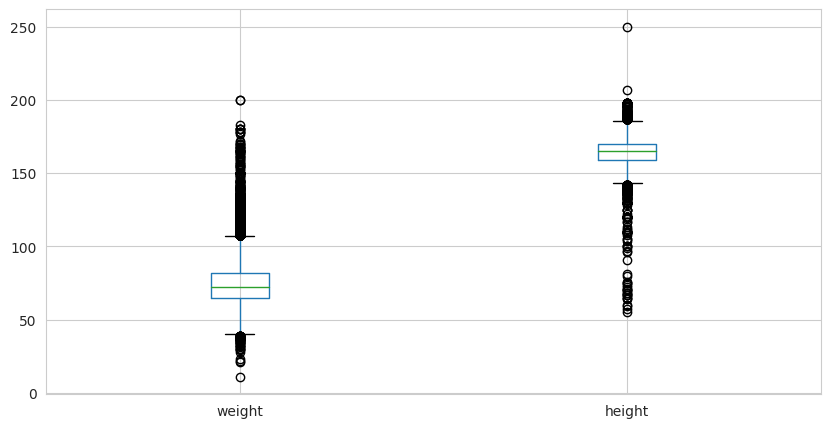

In [216]:
plt.figure(figsize=(10,5))
df.boxplot(['weight','height'])

Outliers = Q1 – 1.5 IQR

Outliers = Q3 + 1.5 IQR

IQR = Q3- Q1

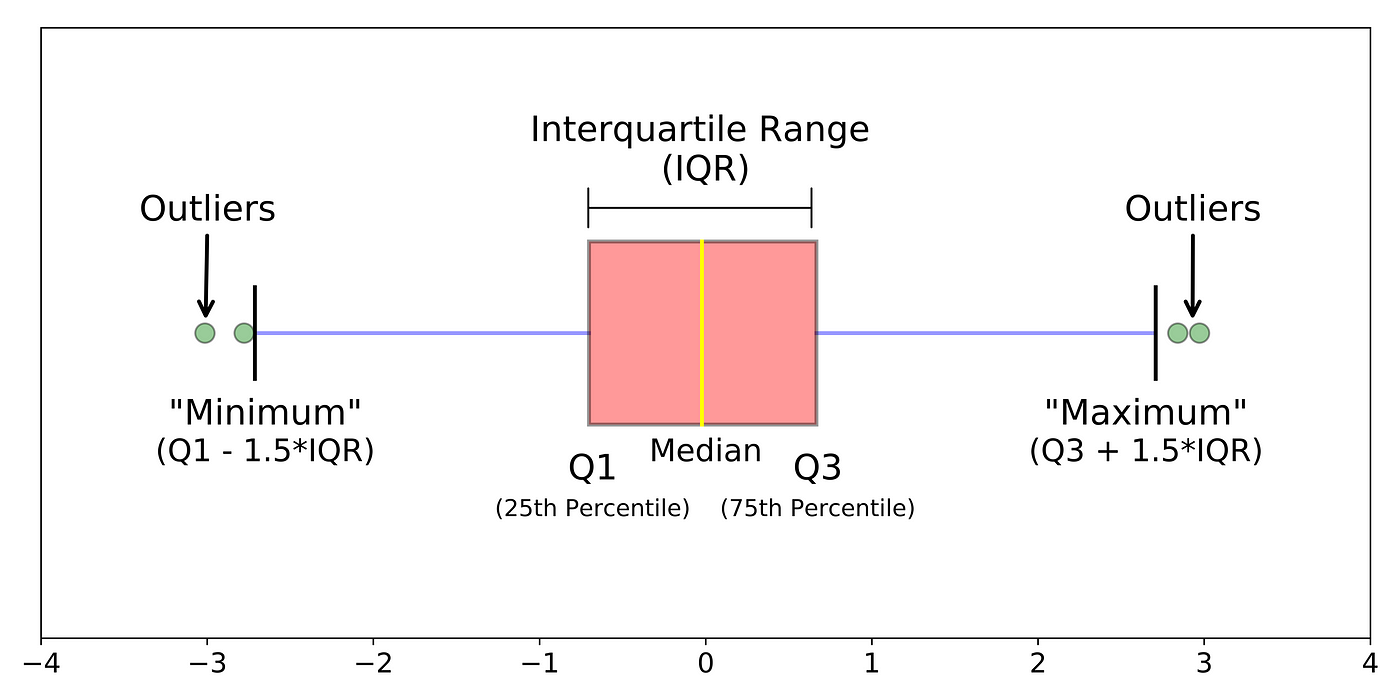

In [217]:
def outliers(df_cardio, drop = False):
    for each_feature in df_cardio.columns:
        feature_data = df_cardio[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range

        outlier_step = IQR * 1.5
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 505
For the feature weight, No of Outliers is 1714


Natural log of a value reduces the variation caused by extreme values.
Taking log will reduce the impact of outliers by compressing the data’s range and bringing extreme values closer to the mean

In [218]:
outlier_free_df = df.copy()
outlier_free_df[['height', 'weight']] = np.log(outlier_free_df[['height', 'weight']])
outliers(outlier_free_df[['height', 'weight']])

For the feature height, No of Outliers is 475
For the feature weight, No of Outliers is 1117


In [219]:
outlier_free_df = outlier_free_df[(outlier_free_df['weight'] > outlier_free_df['weight'].quantile(0.005)) & (outlier_free_df['weight'] < outlier_free_df['weight'].quantile(0.995))]
outline_free_df = outlier_free_df[(outlier_free_df['height'] > outlier_free_df['height'].quantile(0.005)) & (outlier_free_df['height'] < outlier_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 326


In [220]:
outlier_free_df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,pulse
0,50.391781,2,5.123964,4.127134,110,80,1,1,0,0,1,0,30.0
1,55.419178,1,5.049856,4.442651,140,90,3,1,0,0,1,1,50.0
2,51.663014,1,5.105945,4.158883,130,70,3,1,0,0,0,1,60.0
3,48.282192,2,5.129899,4.406719,150,100,1,1,0,0,1,1,50.0
4,47.873973,1,5.049856,4.025352,100,60,1,1,0,0,0,0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,57.736986,1,5.105945,4.382027,150,80,1,1,0,0,1,1,70.0
69995,52.712329,2,5.123964,4.330733,120,80,1,1,1,0,1,0,40.0
69997,52.235616,2,5.209486,4.653960,180,90,3,1,0,1,0,1,90.0
69998,61.454795,1,5.093750,4.276666,135,80,1,2,0,0,0,1,55.0


# Feature Selction using correlation matrix

<Axes: >

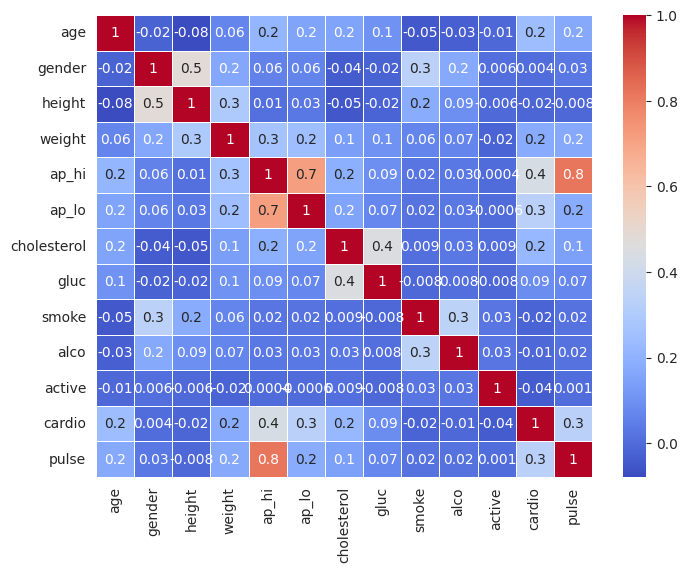

In [221]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(outlier_free_df.corr(), annot = True,cmap= 'coolwarm',ax=ax, fmt='.1g', linewidths=.5)

- ap_hi has the maximum correlation with Target Value

- pulse and ap_lo also have some coorelation with cardio

- Features like gender, height, smoke, alco, active have quite low amount of correlation with target feature

In [222]:
outlier_free_df=outlier_free_df.drop(columns=['gender', 'height', 'smoke', 'alco', 'active'],axis=1)

In [223]:
outlier_free_df

,age,weight,ap_hi,ap_lo,cholesterol,gluc,cardio,pulse
0,50.391781,4.127134,110,80,1,1,0,30.0
1,55.419178,4.442651,140,90,3,1,1,50.0
2,51.663014,4.158883,130,70,3,1,1,60.0
3,48.282192,4.406719,150,100,1,1,1,50.0
4,47.873973,4.025352,100,60,1,1,0,40.0
...,...,...,...,...,...,...,...,...
69994,57.736986,4.382027,150,80,1,1,1,70.0
69995,52.712329,4.330733,120,80,1,1,0,40.0
69997,52.235616,4.653960,180,90,3,1,1,90.0
69998,61.454795,4.276666,135,80,1,2,1,55.0


# converting categorical data to category data type

- gender has 2 categorial values as { 1 : Women, 2 : Male }
- cholesterol has 3 categorial values as { 1: Normal, 2: Above Normal, 3: Well Above Normal }
- gluc has 3 categorial values as { 1: Normal, 2: Above Normal, 3: Well Above Normal }
- Remaining Categories are just binary values

In [224]:
categorical_columns=['cholesterol','gluc']
for col in categorical_columns:
  outlier_free_df[col] = outlier_free_df[col].astype('category')


df_cardio=pd.get_dummies(outlier_free_df)

df_cardio

,age,weight,ap_hi,ap_lo,cardio,pulse,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,50.391781,4.127134,110,80,0,30.0,1,0,0,1,0,0
1,55.419178,4.442651,140,90,1,50.0,0,0,1,1,0,0
2,51.663014,4.158883,130,70,1,60.0,0,0,1,1,0,0
3,48.282192,4.406719,150,100,1,50.0,1,0,0,1,0,0
4,47.873973,4.025352,100,60,0,40.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69994,57.736986,4.382027,150,80,1,70.0,1,0,0,1,0,0
69995,52.712329,4.330733,120,80,0,40.0,1,0,0,1,0,0
69997,52.235616,4.653960,180,90,1,90.0,0,0,1,1,0,0
69998,61.454795,4.276666,135,80,1,55.0,1,0,0,0,1,0


# Scaling the Dataframe

There are some features having a lot of variations and are measured in different units and scaling will help to scale them down in the standard normal distribution

In [225]:
columns_to_scale=['age','weight','ap_hi','ap_lo']
scaler = StandardScaler()
df_cardio[columns_to_scale]= scaler.fit_transform(df_cardio[columns_to_scale])


In [226]:
df_cardio

,age,weight,ap_hi,ap_lo,cardio,pulse,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,-0.434374,-0.911617,-1.023168,-0.122101,0,30.0,1,0,0,1,0,0
1,0.309463,0.881391,0.852207,0.943058,1,50.0,0,0,1,1,0,0
2,-0.246286,-0.731196,0.227082,-1.187260,1,60.0,0,0,1,1,0,0
3,-0.746502,0.677198,1.477333,2.008217,1,50.0,1,0,0,1,0,0
4,-0.806900,-1.490024,-1.648293,-2.252419,0,40.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69994,0.652399,0.536876,1.477333,-0.122101,1,70.0,1,0,0,1,0,0
69995,-0.091033,0.245388,-0.398043,-0.122101,0,40.0,1,0,0,1,0,0
69997,-0.161566,2.082210,3.352708,0.943058,1,90.0,0,0,1,1,0,0
69998,1.202474,-0.061863,0.539645,-0.122101,1,55.0,1,0,0,0,1,0


In [227]:
#splitting the dataswt
X = df_cardio.drop(['cardio'], axis =1)
Y = df_cardio['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle = True)

#KNN

Choosing the best K value

In [256]:
knn_scores=[]
results = []
k_values = [i for i in range (1,21)]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test)),

    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.638770
1    2  0.644438
2    3  0.682439
3    4  0.684657
4    5  0.698802
5    6  0.702647
6    7  0.706886
7    8  0.710681
8    9  0.713884
9   10  0.715856
10  11  0.716891
11  12  0.719454
12  13  0.720538
13  14  0.724629
14  15  0.725713
15  16  0.726551
16  17  0.726453
17  18  0.727734
18  19  0.726403
19  20  0.727389


Text(0, 0.5, 'Accuracy Score')

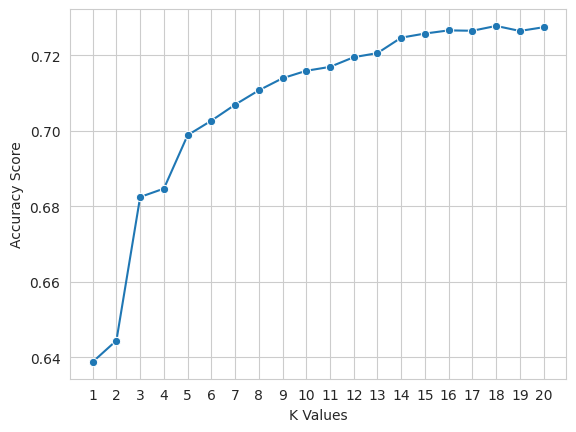

In [257]:
sns.lineplot(x = results['k'], y = results['accuracy'].to_list(), marker = 'o')
plt.xticks(k_values)
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

Choosing k = 18 because it has the highest accuracy

In [247]:
knn1 = KNeighborsClassifier(n_neighbors=18).fit(X_train, y_train)

In [248]:
Y_pred = knn1.predict(X_test)
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75     10272
           1       0.75      0.66      0.71     10017

    accuracy                           0.73     20289
   macro avg       0.73      0.73      0.73     20289
weighted avg       0.73      0.73      0.73     20289



In [249]:
classificationSummary(y_test,Y_pred)

Confusion Matrix (Accuracy 0.7277)

       Prediction
Actual    0    1
     0 8105 2167
     1 3357 6660


# Decision Tree

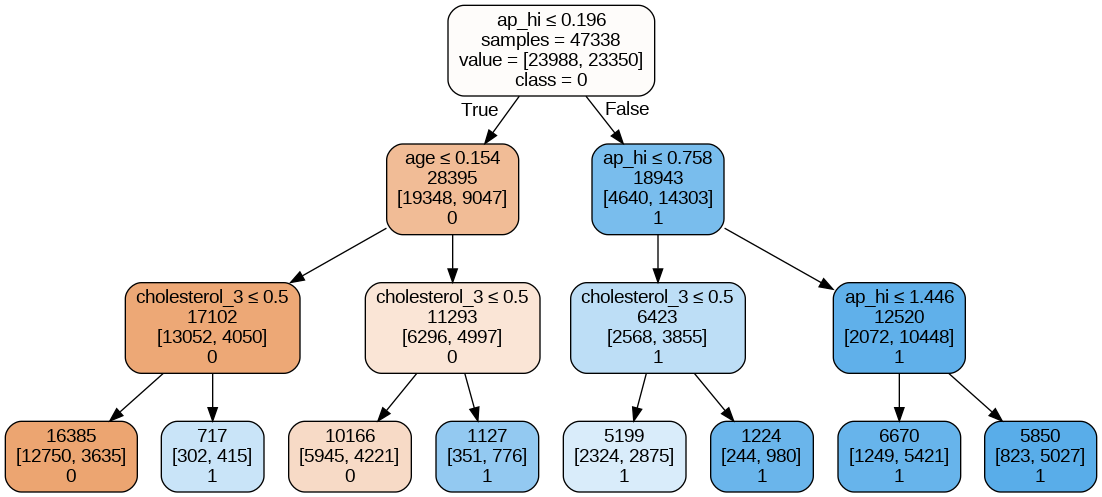

In [274]:
classTree = DecisionTreeClassifier(random_state=63, max_depth=3)
classTree.fit(X_train, y_train)
plotDecisionTree(classTree, feature_names=X_train.columns, class_names=classTree.classes_)

In [275]:
Y_pred_dt = classTree.predict(X_test)

dtree_acc = accuracy_score(y_test, Y_pred_dt)   # accuracy score
cm_dtree = confusion_matrix(y_test, Y_pred_dt) # Confusion matrix

print("Accuracy",dtree_acc)

print(classification_report(y_test, Y_pred_dt))

classificationSummary(y_test,Y_pred_dt)

Accuracy 0.727487801271625
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     10272
           1       0.75      0.67      0.71     10017

    accuracy                           0.73     20289
   macro avg       0.73      0.73      0.73     20289
weighted avg       0.73      0.73      0.73     20289

Confusion Matrix (Accuracy 0.7275)

       Prediction
Actual    0    1
     0 8035 2237
     1 3292 6725


In [276]:
# Five-fold cross-validation of the full decision tree classifier

scores = cross_val_score(classTree, X_train, y_train, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])

Accuracy scores of each fold:  ['0.718', '0.726', '0.725', '0.720', '0.722']


# Logistic regression

In [267]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

lr_acc = accuracy_score(y_test, y_pred_lr)   # accuracy score
cm_lr = confusion_matrix(y_test, y_pred_lr) # Confusion matrix

print('Accuracy ', lr_acc )# accuracy score

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred_lr))

classificationSummary(y_test,y_pred_lr)

Accuracy  0.7278821036029376

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.71      0.79      0.75     10272
           1       0.75      0.67      0.71     10017

    accuracy                           0.73     20289
   macro avg       0.73      0.73      0.73     20289
weighted avg       0.73      0.73      0.73     20289

Confusion Matrix (Accuracy 0.7279)

       Prediction
Actual    0    1
     0 8070 2202
     1 3319 6698


# Random Forest

          feature  importance       std
9          gluc_2    0.003463  0.000995
10         gluc_3    0.003853  0.001123
6   cholesterol_2    0.004346  0.002290
8          gluc_1    0.004753  0.001290
5   cholesterol_1    0.012998  0.011290
7   cholesterol_3    0.015325  0.009557
4           pulse    0.059441  0.044515
3           ap_lo    0.061400  0.046686
2           ap_hi    0.127738  0.070860
1          weight    0.192592  0.011772
0             age    0.514092  0.011919


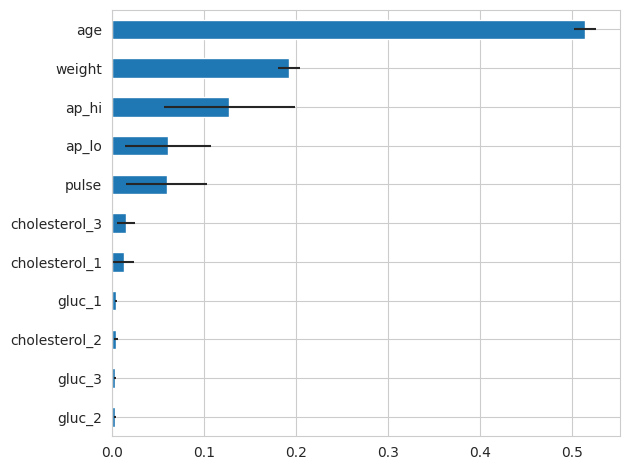

In [268]:

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()


In [270]:

Y_pred_rf = rf.predict(X_test)

rf_tree_acc = accuracy_score(y_test, Y_pred_rf)   # accuracy score
cm_rf_tree = confusion_matrix(y_test, Y_pred_rf) # Confusion matrix

print("Accuracy",rf_tree_acc)

print(classification_report(y_test, Y_pred_rf))

classificationSummary(y_test,Y_pred_rf)

Accuracy 0.6782000098575582
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     10272
           1       0.67      0.69      0.68     10017

    accuracy                           0.68     20289
   macro avg       0.68      0.68      0.68     20289
weighted avg       0.68      0.68      0.68     20289

Confusion Matrix (Accuracy 0.6782)

       Prediction
Actual    0    1
     0 6893 3379
     1 3150 6867


# Model Evaluation

Th recall of all the models lie between 67-79 %

Therfore we are trying to evlaluate the model using AUC and ROC curve

Its the ability of the model to seperate positive classes from negative classes

In [280]:
pred_prob_knn= knn1.predict_proba(X_test)
pred_prob_dt = classTree.predict_proba(X_test)
pred_prob_logreg= logreg.predict_proba(X_test)
pred_prob_rf = rf.predict_proba(X_test)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob_knn[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob_dt[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob_logreg[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob_rf[:,1])

print(auc_score1, auc_score2,auc_score3,auc_score4)

0.784213196600048 0.7812404951302413 0.7928217561687189 0.7428089245945444


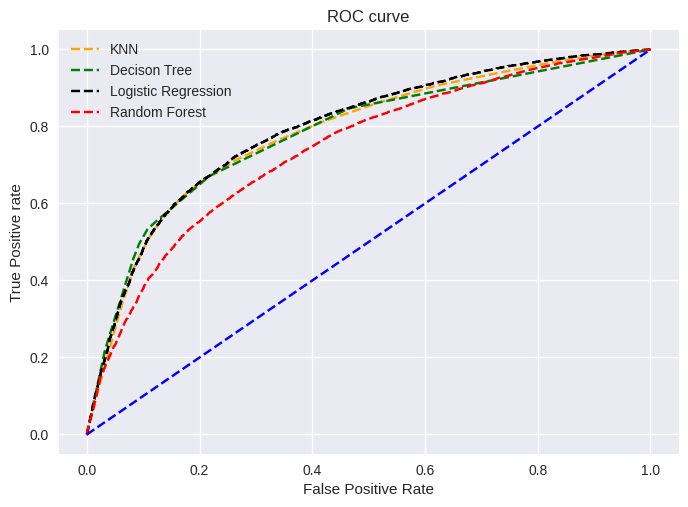

In [282]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')


from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_dt[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob_logreg[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decison Tree')
plt.plot(fpr3, tpr3, linestyle='--',color='black', label='Logistic Regression')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='Random Forest')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()


# Conclusion

Although Random forest has the highest recall, it does not have good accuracy in terms of classification

It is evident from the plot that the AUC for the Logistic Regression ROC curve is higher than that for the KNN , Random Forest and Decision Tree ROC curve.

Therefore, we can say that logistic regression did a better job of classifying the positive class in the dataset.

